In [1]:
from os import listdir
from os.path import isfile
from fnmatch import fnmatch
from math import isnan, ceil
from pprint import pprint
from statistics import median
from re import match, split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

In [91]:
def get_ratio(filename, mw=False):
    i = 0
    if mw:
        i = 1
    return filename.split('_')[i].replace('ratio','')

In [92]:
def get_run(filename, mw=False):
    i = 1
    if mw:
        i = 2
    return int(filename.split('_')[i].replace('run',''))

In [93]:
def get_vcs(filename, mw=False):
    i = 2
    if mw:
        i = 3
    return int(filename.split('_')[i].replace('vclients',''))

In [94]:
def get_worker_threads(filename, mw=False):
    i = 3
    if mw:
        i = 4 
        return int(filename.split('_')[i].replace('workerthreads', '').replace('.log', ''))
    return int(filename.split('_')[i].replace('workerthreads', ''))

In [95]:
def get_client(filename):
    return int(filename.split('_')[4].replace('client', ''))

In [96]:
def get_instance(filename):
    return int(filename.split('_')[-1].replace('instance','').replace('.log', ''))

In [97]:
def get_mw(filename):
    return int(filename.split('_')[0].replace('stats', ''))

In [98]:
def roundup(x):
    return int(ceil(x / 1.0)) * 1

In [99]:
def parse_content(path, filename):
    secs_pat = '\[RUN #1 \d+%,\s+(\d+) secs'
    SECS = 70.0
    GET_TOTAL = 0.0
    SET_TOTAL = 0.0
    approx_rt = []
    percent = 0.0

    with (open(path+filename, 'r')) as file:
        for line in file.readlines():
            m = match(secs_pat, line)
            if line.startswith('Sets'):
                m = match("Sets\s+(\d+.\d+)", line)
                SET_TOTAL = SECS * float(m.group(1))
            elif line.startswith('Gets'):
                m = match("Gets\s+(\d+.\d+)", line)
                GET_TOTAL = SECS * float(m.group(1))
            elif line.startswith('GET'):
                m = match("GET\s+(\d+.\d+)\s+(\d+.\d+)", line)
                count = (float(m.group(2)) - percent) / 100.0 * GET_TOTAL
                percent = float(m.group(2))
                approx_rt.extend([float(m.group(1))] * int(count))
    return approx_rt

In [171]:
def get_avg_rt(df, typ, ratios, worker_threads, vclients, runs, threads, instances, clients):
    rts = []
    stds = []
    ils = []
    fig, ax = plt.subplots()
    width = 20
    base = 5
    separator = 2
    prev = base
    xticks = []
    xticklabels = []
    for j, ratio in enumerate(ratios):
        mget = ratio.split(':')[-1]
        whole = []
        cols = ['RT', '25th', '50th', '75th', '90th', '99th']
        values = []
        xs = []
        
        for i, col in enumerate(cols):
            if typ == 'MT':
                values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().unstack().T.mean().mean())
            else:
                values.append(df.unstack().loc[(ratio, worker_threads[0], vclients[0]), col].T.mean().mean())
            x = int(prev + width + separator)
            xs.append(x)
            prev = x
            
        prev += width
        
        xticks.extend(xs)
        cols[0] = 'AVG RT'
        xticklabels.extend(cols)
        
        bs = plt.bar(xs, values, width)
        
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_axisbelow(True)
    
    plt.grid(b=True, which='major', axis='y', color='0.65', linestyle='dotted')
    plt.ylabel("Response Time (msec)")
    plt.legend(labels=['%d KEYs' % x for x in [1, 3, 6, 9]], frameon=False, loc='top', ncol=2)
    if typ == 'MT':
        title = 'MEMTIER'
    else:
        title = 'MIDDLEWARE'
    
    op = 'non_sharded_multigets' 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize('x-small')
        tick.label.set_rotation('vertical')
    
    filename = ('rt_%s_%s' % (title, op)).lower()
    plt.savefig('img/%s.png' % filename, bbox_inches='tight')

    return rts, stds

/home/peveloper/.local/lib/python3.6/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "top". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


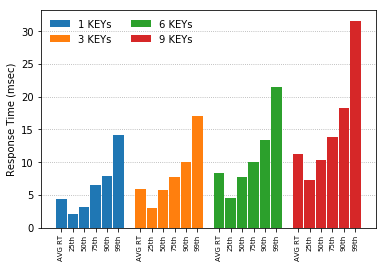

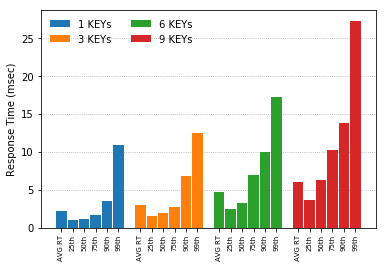

In [172]:
timestamp = '20181120220416'
log_dir = 'logs/%s/' % timestamp

logs = [f for f in listdir(log_dir) if fnmatch(f, '*.log')]

m = '^ratio(.*)'
memtier_logs = [f for f in logs if match(m, f)]
mw = '^stats(.*)'
middleware_logs = [f for f in logs if match(mw, f)]

ratios = ['1:1', '1:9', '1:18', '1:27']
runs = [x for x in range(1, 3 + 1)] 
instances = [x for x in range(1, 2 + 1)]
threads = 1 
clients = [x for x in range(1, 3 + 1)]
vclients = [2]
worker_threads = [64]
mws = [x for x in range(1, 2 + 1)]

mt_multi_index = [ratios, worker_threads, vclients, runs, clients, instances]
mw_multi_index = [ratios, worker_threads, vclients, runs, mws]

mt_len_index = len(ratios) * len(worker_threads) * len(vclients) * len(runs) * len(clients) * len(instances)
mw_len_index = len(ratios) * len(worker_threads) * len(vclients) * len(runs) * len(mws)

mt_index = pd.MultiIndex.from_product(mt_multi_index, names=['ratio', 'WTS', 'VCs', 'run', 'client', 'instance'])
mw_index = pd.MultiIndex.from_product(mw_multi_index,)
columns = ['TP', 'RT', '25th', '50th', '75th', '90th', '99th']
pd.set_option("display.precision", 2)

mt_template = pd.DataFrame([[.0] * len(columns)] * mt_len_index, index=mt_index, columns=columns)
mw_template = pd.DataFrame([[.0] * len(columns)] * mw_len_index, index=mw_index, columns=columns)

for log_file in memtier_logs: 

    ratio = get_ratio(log_file) 
    run = get_run(log_file)
    vcs = get_vcs(log_file)
    client = get_client(log_file)
    instance = get_instance(log_file)
    wts = get_worker_threads(log_file)

    table_offset = 0
    i=0
    
    avg_rt = parse_content(log_dir, log_file)
    
    mt_template.loc[(ratio, wts, vcs, run, client, instance), 'RT'] = np.mean(avg_rt)
    
    with (open(log_dir+log_file, 'r')) as file:
        passed_25 = False
        passed_50 = False
        passed_75 = False
        passed_90 = False
        passed_99 = False 
        
        lines = file.readlines()
        
        for line in lines:
            contents = split(r"\s", line)
            contents = list(filter(None, contents))

            if len(contents) < 3:
                continue

            if contents[0] == "GET" and float(contents[2]) > 25:
                if not passed_25:
                    mt_template.loc[(ratio, wts, vcs, run, client, instance), '25th'] = float(contents[1])
                passed_25 = True
            if contents[0] == "GET" and float(contents[2]) > 50:
                if not passed_50:
                    mt_template.loc[(ratio, wts, vcs, run, client, instance), '50th'] = float(contents[1])
                passed_50 = True
            if contents[0] == "GET" and float(contents[2]) > 75:
                if not passed_75:
                    mt_template.loc[(ratio, wts, vcs, run, client, instance), '75th'] = float(contents[1])
                passed_75 = True
            if contents[0] == "GET" and float(contents[2]) > 90:
                if not passed_90:
                    mt_template.loc[(ratio, wts, vcs, run, client, instance), '90th'] = float(contents[1])
                passed_90 = True
            if contents[0] == "GET" and float(contents[2]) > 99:
                if not passed_99:
                    mt_template.loc[(ratio, wts, vcs, run, client, instance), '99th'] = float(contents[1])
                passed_99 = True
        
rts, stds = get_avg_rt(mt_template, 'MT', ratios, worker_threads, vclients, runs, threads, len(instances), len(clients))

for log_file in middleware_logs:
    ratio = get_ratio(log_file, True) 
    run = get_run(log_file, True)
    vcs = get_vcs(log_file, True)
    wts = get_worker_threads(log_file, True)
    mw = get_mw(log_file)

    with (open(log_dir+log_file, 'r')) as file:
        lines = file.readlines()

        h_offset = -1
        g_offset = -1
        
        for i, line in enumerate(lines):
            if "Interval" in line:
                h_offset = i
            if "GET" in line and h_offset != -1:
                g_offset = i
                break
        table = pd.read_table(log_dir+log_file, skiprows=2, engine='python', nrows=h_offset -3, skipinitialspace=True, sep=',\s*', index_col=0, names=['Elapsed Time', 'AVG Throughput', 'AVG Queue Size', 'AVG Waiting Time', 'AVG Service Time', 'AVG Response Time', 'AVG SET Response Time', 'AVG GET Response Time', 'AVG MULTI-GET Response Time', '#SETS', '#GETS', '#MULTIGETS', 'GET MissRatio', 'MULTI-GET MissRatio', 'AVG MULTI-GET Size'])
        table = table.astype('float32')
        
        histo = pd.read_table(log_dir+log_file, skiprows=g_offset, engine='python', skipinitialspace=True, sep=',\s*', index_col=[0], names=['Type', '<= msec', 'Requests'])
        histo = histo.dropna()
        histo = histo.astype('float32')
        total = histo['Requests'].sum()
        
        histo['Percent'] =  histo['Requests'] * 100.0 / total
        histo['Percent'] = histo['Percent'].cumsum()
        
        thresholds = [25, 50, 75, 90, 99]
        
        for j, col in enumerate(thresholds):
            dt = histo.loc[histo['Percent'] <= float(col), '<= msec']
            mw_template.loc[(ratio, wts, vcs, run, mw), '%dth' % col] = round(dt.values.tolist()[-1], 2)
        
        sets = table['#SETS'].sum()
        gets = table['#GETS'].sum()
        multi = table['#MULTIGETS'].sum()
        
        mw_template.loc[(ratio, wts, vcs, run, mw), 'TP'] = ((sets + gets + multi) / 70.0)
        mw_template.loc[(ratio, wts, vcs, run, mw), 'RT'] = table['AVG Response Time'].mean()
        
rts, stds = get_avg_rt(mw_template, 'MW', ratios, worker_threads, vclients, runs, threads, len(instances), len(clients))